# FINAL Time Series Assignment - Jesús Navarro

We start by loading the libraries to work with. 

In [62]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme(style="darkgrid")
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

### Data Loading

In [21]:
### Leer datos de archivo powercompsution.csv

datos = pd.read_csv('powerconsumption.csv')
temp_serie = datos[['Datetime', 'Temperature']]
temp_serie['Datetime'] = pd.to_datetime(temp_serie['Datetime'], format='%m/%d/%Y %H:%M')
temp_serie.index = temp_serie['Datetime']
del temp_serie['Datetime']
# Agrupar por hora tomando la media de cada 6 valores (10 minutos * 6 = 1 hora)
temp_serie_hourly = temp_serie.resample('H').mean()
temp_serie_hourly = temp_serie_hourly.iloc[:168]
print(f'\nRango de fechas: {temp_serie_hourly.index.min()}/{temp_serie_hourly.index.max()}')
temp_serie_hourly.head()


Rango de fechas: 2017-01-01 00:00:00/2017-01-07 23:00:00


C:\Users\jesnavar\AppData\Local\Temp\ipykernel_27576\1132222109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_serie['Datetime'] = pd.to_datetime(temp_serie['Datetime'], format='%m/%d/%Y %H:%M')


,Temperature
Datetime,
2017-01-01 00:00:00,6.196833
2017-01-01 01:00:00,5.548833
2017-01-01 02:00:00,5.054333
2017-01-01 03:00:00,5.004333
2017-01-01 04:00:00,5.097667


### 2. Graphical representation of the time series and decomposition.

(array([17167., 17168., 17169., 17170., 17171., 17172., 17173., 17174.]),
 [Text(17167.0, 0, '2017-01-01'),
  Text(17168.0, 0, '2017-01-02'),
  Text(17169.0, 0, '2017-01-03'),
  Text(17170.0, 0, '2017-01-04'),
  Text(17171.0, 0, '2017-01-05'),
  Text(17172.0, 0, '2017-01-06'),
  Text(17173.0, 0, '2017-01-07'),
  Text(17174.0, 0, '2017-01-08')])

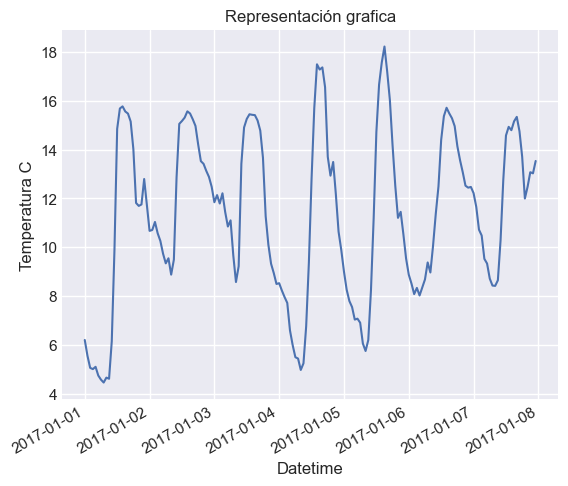

In [22]:
### Representación grafica. 
sns.lineplot(temp_serie_hourly['Temperature'])
#plt.plot(temp_serie_hourly['Temperature'])
plt.title("Representación grafica")
plt.ylabel("Temperatura C", fontsize=12)
plt.xticks(rotation=30, ha='right')

Since the variability is constant, we will use an additive scheme for decomposition. As there is no clear trend, we will only test the additive scheme.

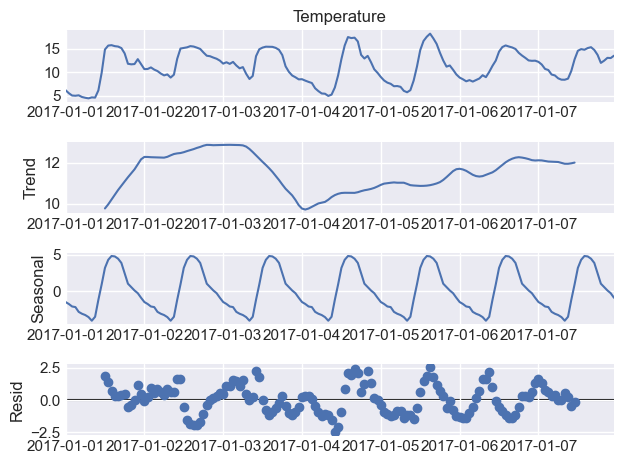

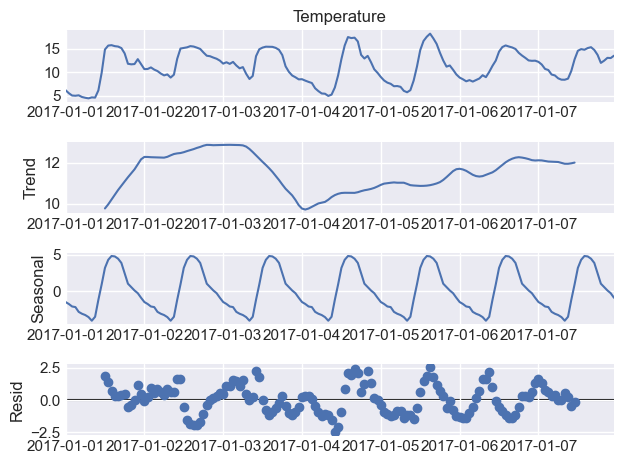

In [23]:
### Time series decomposition
result = seasonal_decompose(temp_serie_hourly['Temperature'], model= 'additive')
result.plot()

In [24]:
### Show seasonal coefficients
print(result.seasonal)

Datetime
2017-01-01 00:00:00   -1.506213
2017-01-01 01:00:00   -1.777104
2017-01-01 02:00:00   -2.122220
2017-01-01 03:00:00   -2.204101
2017-01-01 04:00:00   -2.865593
                         ...   
2017-01-07 19:00:00    1.023215
2017-01-07 20:00:00    0.555815
2017-01-07 21:00:00    0.088759
2017-01-07 22:00:00   -0.290740
2017-01-07 23:00:00   -0.922527
Freq: H, Name: seasonal, Length: 168, dtype: float64


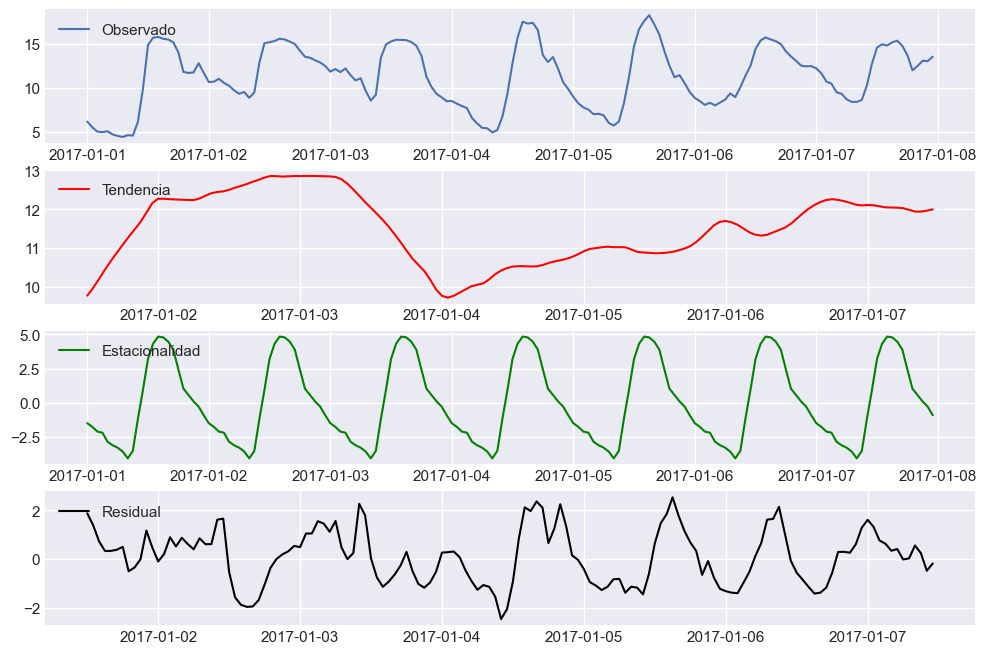

In [25]:
# Visualizar las componentes
result = seasonal_decompose(temp_serie_hourly['Temperature'], model= 'additive')
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia', color = 'red')
plt.legend(loc='upper left')
#Componente 2
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad', color = 'green')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color = 'black')
plt.legend(loc='upper left')
plt.show()

In [26]:
## Horas mas calientes y frias del día:
import calendar

# agrupar por hora.
seasonal = result.seasonal
avg_by_hour = seasonal.groupby(seasonal.index.hour).mean()

# hour number and value
best_hour_num = avg_by_hour.idxmax()
best_hour_avg = avg_by_hour.max()
worst_hour_num = avg_by_hour.idxmin()
worst_hour_avg = avg_by_hour.min()

print(f"La hora mas caliente del día en promedio es"
      f"{best_hour_num} ({best_hour_num}), "
      f"con un factor estacional medio de {best_hour_avg:.3f}.")

print(f"La hora mas fría del día en promedio es "
      f"{worst_hour_num} ({worst_hour_num}), "
      f"con un factor estacional medio de {worst_hour_avg:.3f}.")

La hora mas caliente del día en promedio es14 (14), con un factor estacional medio de 4.839.
La hora mas fría del día en promedio es 8 (8), con un factor estacional medio de -4.085.


### Representación grafica de la serie, estacionalidad y tendencia
Hacemos este apartado para generar nuevo grafico de las series. 

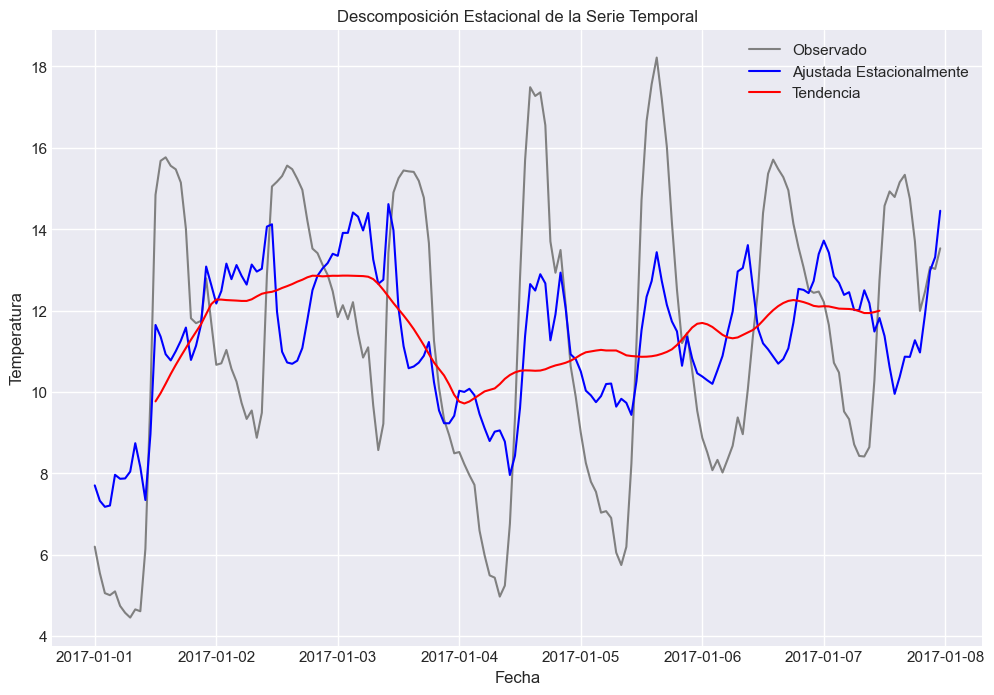

In [27]:
# Crear un gráfico que muestre las componentes
plt.figure(figsize=(12, 8))
plt.plot(result.observed, label='Observado', color='grey')
plt.plot(result.observed-result.seasonal,  #Se hace la resta debido a que es un esquema aditivo. 
label='Ajustada Estacionalmente', color='blue')
plt.plot(result.trend, label='Tendencia', color='red')
# Añadir leyendas y título
plt.legend()
plt.title('Descomposición Estacional de la Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
# Mostrar el gráfico
plt.show()

# Modelos predictivos de alisado exponencial. 
En este apartado vamos a hacer predicciones de 24 horas para los 3 modelos de alisado: simple, doble, y holt-winters.

In [ ]:
#Crear los datos sin las últimas 24 horas. 
temperatura_tr = temp_serie_hourly.Temperature.loc[:'2017-01-06']
temperatura_tr.index.freq = 'H'
temperatura_tr.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-01-06 14:00:00', '2017-01-06 15:00:00',
               '2017-01-06 16:00:00', '2017-01-06 17:00:00',
               '2017-01-06 18:00:00', '2017-01-06 19:00:00',
               '2017-01-06 20:00:00', '2017-01-06 21:00:00',
               '2017-01-06 22:00:00', '2017-01-06 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=144, freq='H')

In [29]:
# MODELO ALISADO SIMPLE###
modelo_ses = sm.tsa.SimpleExpSmoothing(temperatura_tr , initialization_method="estimated").fit()
# Para seleccionar distintas alphas, fit(smoothing_level=alpha)
# Calcular la predicción para 24 horas.
temp_s1 = modelo_ses.forecast(steps=24)
# Para ver parámetros, e.g.: alpha = 0.995
modelo_ses.summary()

Dep. Variable:,Temperature,No. Observations:,144
Model:,SimpleExpSmoothing,SSE,213.866
Optimized:,True,AIC,60.958
Trend:,None,BIC,66.897
Seasonal:,None,AICC,61.245
Seasonal Periods:,None,Date:,"mié, 28 may. 2025"
Box-Cox:,False,Time:,21:15:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,6.1968333,l.0,True


In [30]:
### MODELO ALISADO DOBLE ###
# Aplicar suavizado exponencial doble (Holt).
modelo_holt = sm.tsa.ExponentialSmoothing(temperatura_tr, trend='add', damped_trend=False).fit()
# Obtener predicciones para 24 horas
temp_s2 = modelo_holt.forecast(steps=24)
# Mostrar la descripción del modelo
modelo_holt.summary()

Dep. Variable:,Temperature,No. Observations:,144
Model:,ExponentialSmoothing,SSE,144.170
Optimized:,True,AIC,8.169
Trend:,Additive,BIC,20.049
Seasonal:,None,AICC,8.783
Seasonal Periods:,None,Date:,"mié, 28 may. 2025"
Box-Cox:,False,Time:,21:15:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,1.0000000,beta,True


In [31]:
### MODELO HOLT-WINTERS ADITIVO ####
# Aplicar suavizado Holt-Winters. .fit(smoothing.seasonal = gamma).
modelo_holt_winters_add = sm.tsa.ExponentialSmoothing(temperatura_tr, trend='add', seasonal='add', seasonal_periods=24).fit()
# Obtener predicciones para 24 horas.
temp_s3 = modelo_holt_winters_add.forecast(steps=24)
# Mostrar la descripción del modelo
modelo_holt_winters_add.summary()

Dep. Variable:,Temperature,No. Observations:,144
Model:,ExponentialSmoothing,SSE,64.751
Optimized:,True,AIC,-59.095
Trend:,Additive,BIC,24.060
Seasonal:,Additive,AICC,-42.635
Seasonal Periods:,24,Date:,"mié, 28 may. 2025"
Box-Cox:,False,Time:,21:15:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [32]:
### MODELO HOLT-WINTERS MULTIPLICATIVO ####
# Aplicar suavizado Holt-Winters. .fit(smoothing.seasonal = gamma).
modelo_holt_winters_mult = sm.tsa.ExponentialSmoothing(temperatura_tr, trend='multiplicative', seasonal='multiplicative', seasonal_periods=24).fit()
# Obtener predicciones para 24 horas.
temp_s4 = modelo_holt_winters_mult.forecast(steps=24)
# Mostrar la descripción del modelo
modelo_holt_winters_mult.summary()

Dep. Variable:,Temperature,No. Observations:,144
Model:,ExponentialSmoothing,SSE,79.149
Optimized:,True,AIC,-30.181
Trend:,Multiplicative,BIC,52.974
Seasonal:,Multiplicative,AICC,-13.721
Seasonal Periods:,24,Date:,"mié, 28 may. 2025"
Box-Cox:,False,Time:,21:15:10
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


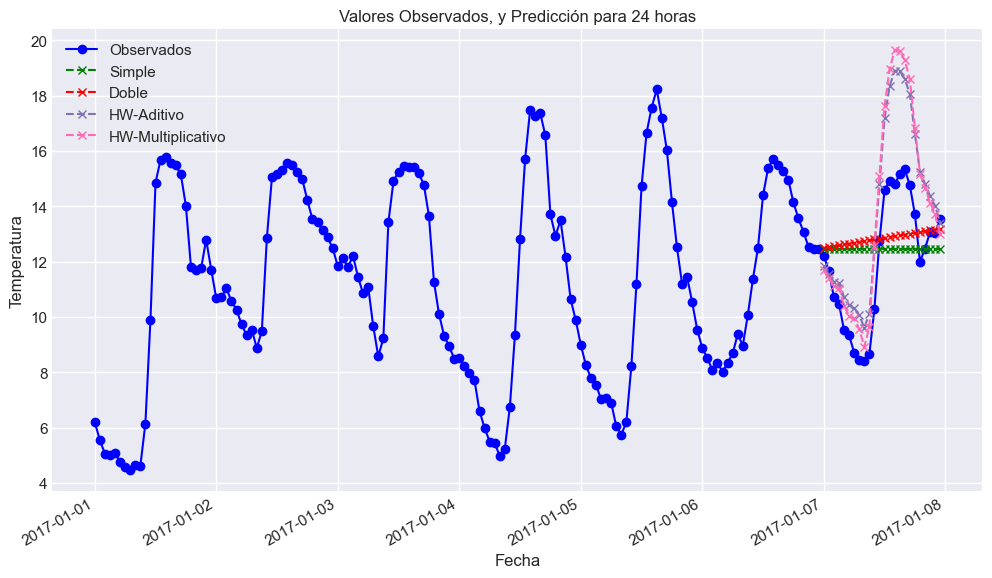

In [33]:
### GRAFICAR TODOS LOS MODELOS
plt.figure(figsize=(12, 6))
plt.plot(temp_serie_hourly.index, temp_serie_hourly['Temperature'], label='Observados', marker='o', linestyle='-', color='blue')
#plt.plot(vuelos.index, modelo_holt.fittedvalues, label='Holt', linestyle='--', color='orange')
plt.plot(temp_s1.index, temp_s1, label='Simple', linestyle='--',color='green', marker='x')
plt.plot(temp_s2.index, temp_s2, label='Doble', linestyle='--', color='red', marker='x')
plt.plot(temp_s3.index, temp_s3, label='HW-Aditivo', linestyle='--', color='m', marker = 'x')
plt.plot(temp_s4.index, temp_s4, label='HW-Multiplicativo', linestyle='--', color='hotpink', marker = 'x')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.title('Valores Observados, y Predicción para 24 horas')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

# Second Part: ARMA and ARIMA Models. 

We will begin by checking the stationarity of the series using the ADF and KPSS statistical tests.

In [37]:
##Test de estacionariedad de serie original
print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(temp_serie_hourly)
kpss_result = kpss(temp_serie_hourly)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.327803428023784, p-value: 4.794358259645007e-06
KPSS Statistic: 0.10446439612849931, p-value: 0.1


c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


We continue with graph of ACF

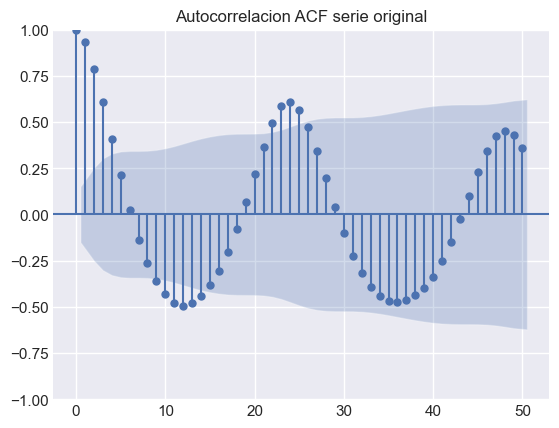

<Figure size 800x600 with 0 Axes>

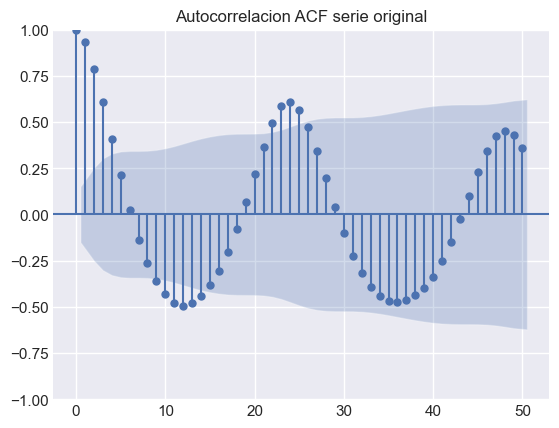

In [43]:
#GRAFICO DE ACF
plt.figure(figsize=(8,6))
plot_acf(temp_serie_hourly, title="Autocorrelacion ACF serie original", lags=50, alpha=0.05)

Now we do the graph of PACF

c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


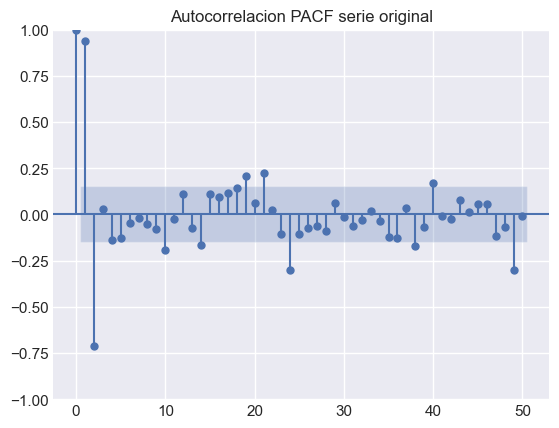

<Figure size 800x600 with 0 Axes>

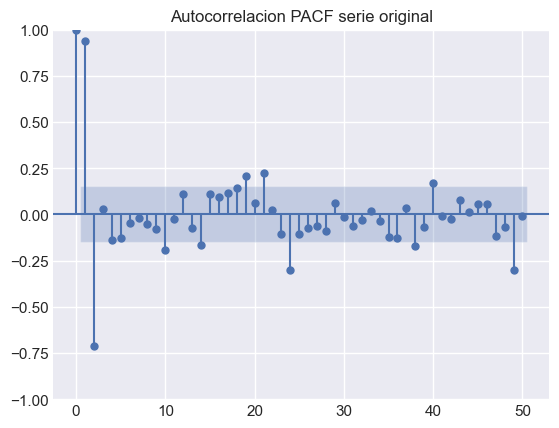

In [44]:
#GRAFICO DE PACF
plt.figure(figsize=(8,6))
plot_pacf(temp_serie_hourly, title="Autocorrelacion PACF serie original", lags=50, alpha=0.05)

# SARIMA PART
Check whether the series differenced at lag 24 is seasonal.

In [46]:
temp_serie_hourly_diff = temp_serie_hourly.diff(24)
temp_serie_hourly_diff_clean = temp_serie_hourly_diff.dropna()
##Test de estacionariedad de serie diferenciada
print('Test estacionariedad serie diferenciada')
print('-------------------------------------')
adfuller_result = adfuller(temp_serie_hourly_diff_clean)
kpss_result = kpss(temp_serie_hourly_diff_clean)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie diferenciada
-------------------------------------
ADF Statistic: -3.6445775857463807, p-value: 0.004963810786720425
KPSS Statistic: 0.19219032752438686, p-value: 0.1


c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Create graph of ACF y PACF for differenced series. 

c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


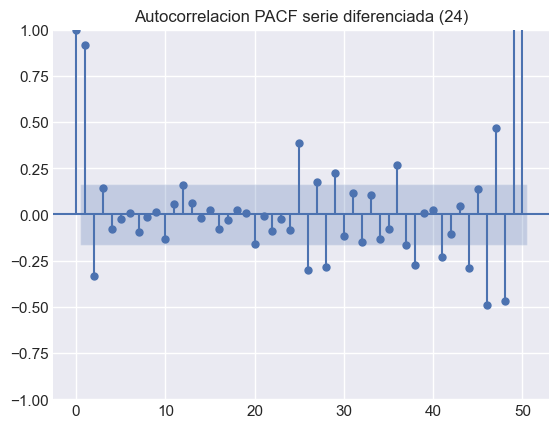

<Figure size 800x600 with 0 Axes>

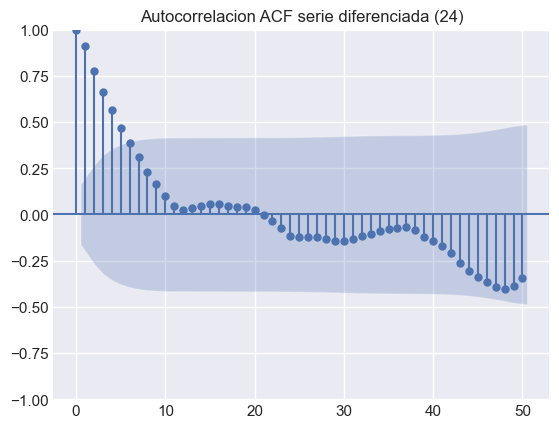

<Figure size 800x600 with 0 Axes>

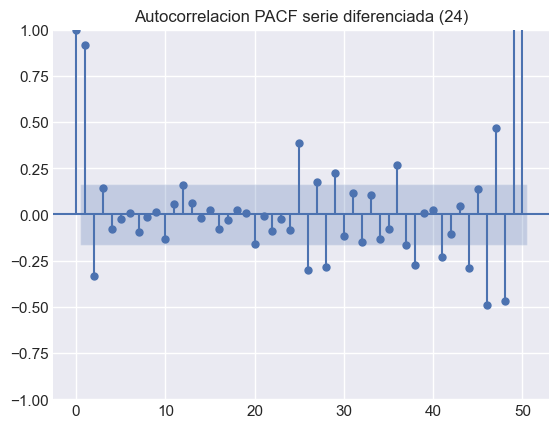

In [49]:
#Graficos serie diferenciada
#GRAFICO DE ACF
plt.figure(figsize=(8,6))
plot_acf(temp_serie_hourly_diff_clean, title="Autocorrelacion ACF serie diferenciada (24)", lags=50, alpha=0.05)
#GRAFICO DE PACF
plt.figure(figsize=(8,6))
plot_pacf(temp_serie_hourly_diff_clean, title="Autocorrelacion PACF serie diferenciada (24)", lags=50, alpha=0.05)

In [66]:
#Ajuste modelo SARIMAX
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = temperatura_tr, order = (2, 0, 4), seasonal_order = (2, 1, 5, 24))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` is de

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                      Temperature   No. Observations:                  144
Model:             SARIMAX(2, 0, 4)x(2, 1, [1, 2, 3, 4, 5], 24)   Log Likelihood                -138.020
Date:                                         mié, 28 may. 2025   AIC                            304.039
Time:                                                  23:47:36   BIC                            343.064
Sample:                                              01-01-2017   HQIC                           319.887
                                                   - 01-06-2017                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3778      0.546      0.691      0.489      -0.693       1.449
ar.L2          0.4790      0.513      0.934      0.351      -0.527       1.485
ma.L1          0.8801      0.548      1.606      0.108      -0.194       1.954
ma.L2          0.0830      0.243      0.341      0.733      -0.394       0.560
ma.L3         -0.1815      0.197     -0.921      0.357      -0.568       0.205
ma.L4          0.0391      0.212      0.184      0.854      -0.377       0.455
ar.S.L24       0.1614    671.557      0.000      1.000   -1316.066    1316.389
ar.S.L48      -0.9328    299.494     -0.003      0.998    -587.931     586.065
ma.S.L24      -1.1926   3110.433     -0.000      1.000   -6097.529    6095.144
ma.S.L48       1.7730   3637.647      0.000      1.000   -7127.883    7131.430
ma.S.L72      -1.3049   1099.253     -0.001      0.999   -2155.801    2153.191
ma.S.L96       1.1480   1142.054      0.001      0.999   -2237.236    2239.532
ma.S.L120     -0.3519   1838.554     -0.000      1.000   -3603.852    3603.148
sigma2         0.1969    271.983      0.001      0.999    -532.881     533.274
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.21
Prob(Q):                              0.94   Prob(JB):                         0.07
Heteroskedasticity (H):               0.70   Skew:                            -0.32
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Comprobar con los valores futuros
# Predicción ARIMA Manual
predicciones_statsmodels = modelo_res.get_forecast(steps=24).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
# se comprueba lo predicho con los valores reales
#Crear datos futuros 
datos_futuros = temp_serie_hourly.Temperature.loc['2017-01-07':]
datos_futuros.index.freq = 'H'
datos_futuros.index

DatetimeIndex(['2017-01-07 00:00:00', '2017-01-07 01:00:00',
               '2017-01-07 02:00:00', '2017-01-07 03:00:00',
               '2017-01-07 04:00:00', '2017-01-07 05:00:00',
               '2017-01-07 06:00:00', '2017-01-07 07:00:00',
               '2017-01-07 08:00:00', '2017-01-07 09:00:00',
               '2017-01-07 10:00:00', '2017-01-07 11:00:00',
               '2017-01-07 12:00:00', '2017-01-07 13:00:00',
               '2017-01-07 14:00:00', '2017-01-07 15:00:00',
               '2017-01-07 16:00:00', '2017-01-07 17:00:00',
               '2017-01-07 18:00:00', '2017-01-07 19:00:00',
               '2017-01-07 20:00:00', '2017-01-07 21:00:00',
               '2017-01-07 22:00:00', '2017-01-07 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq='H')

c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
c:\Users\jesnavar\AppData\Local\anaconda3\envs\serieTemp\Lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


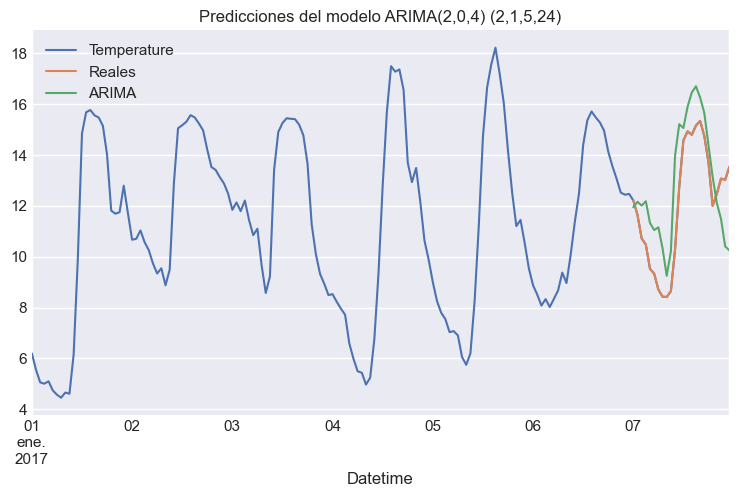

In [68]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
temp_serie_hourly.plot(ax=ax, label='Serie')
datos_futuros.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.set_title('Predicciones del modelo ARIMA(2,0,4) (2,1,5,24)')
ax.legend()
plt.show()

In [69]:
##VALIDACION DEL MODELO NUMERICO
# Mean Squared Error (MSE)
mse = mean_squared_error(datos_futuros,
predicciones_statsmodels)
print(f'Mean Squared Error (MSE): {mse}')
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
# Mean Absolute Error (MAE)
mae = mean_absolute_error(datos_futuros,
predicciones_statsmodels)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 3.065820291869558
Root Mean Squared Error (RMSE): 1.750948397831746
Mean Absolute Error (MAE): 1.514957338630211


In [70]:
### AUTOARIMA
modelo2 = auto_arima(
y = temperatura_tr,
start_p = 0,
start_q = 0,
max_p = 5,
max_q = 5,
seasonal = True,
test = 'adf',
m = 24, # periodicidad de la estacionalidad
d = None, # El algoritmo determina 'd'
D = None, # El algoritmo determina 'D'
trace = True,
error_action = 'ignore',
suppress_warnings = True,
stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=677.230, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=781.124, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=406.025, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=564.194, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1120.994, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=470.558, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=404.641, Time=1.43 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=695.925, Time=1.57 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=362.943, Time=1.97 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=366.505, Time=0.65 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept   : AIC=363.4

In [73]:
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 24)   Log Likelihood                -172.177
Date:                            mié, 28 may. 2025   AIC                            360.355
Time:                                     23:51:01   BIC                            384.113
Sample:                                 01-01-2017   HQIC                           370.009
                                      - 01-06-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3299      0.152      2.173      0.030       0.032       0.627
ar.L1          1.7764      0.099     17.952      0.000       1.582       1.970
ar.L2         -0.8304      0.082    -10.084      0.000      -0.992      -0.669
ma.L1         -0.2498      0.121     -2.057      0.040      -0.488      -0.012
ma.L2         -0.3454      0.126     -2.750      0.006      -0.592      -0.099
ar.S.L24       0.2374      0.077      3.078      0.002       0.086       0.389
ar.S.L48       0.2181      0.119      1.836      0.066      -0.015       0.451
sigma2         0.6057      0.078      7.813      0.000       0.454       0.758
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                20.83
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### REALIZAR PREDICCIONES DEL MODELO AUTOARIMA
predicciones_statsmodels2 = modelo2.predict(n_periods=24)
predicciones_statsmodels2.name = 'Predicciones AUTOARIMA'

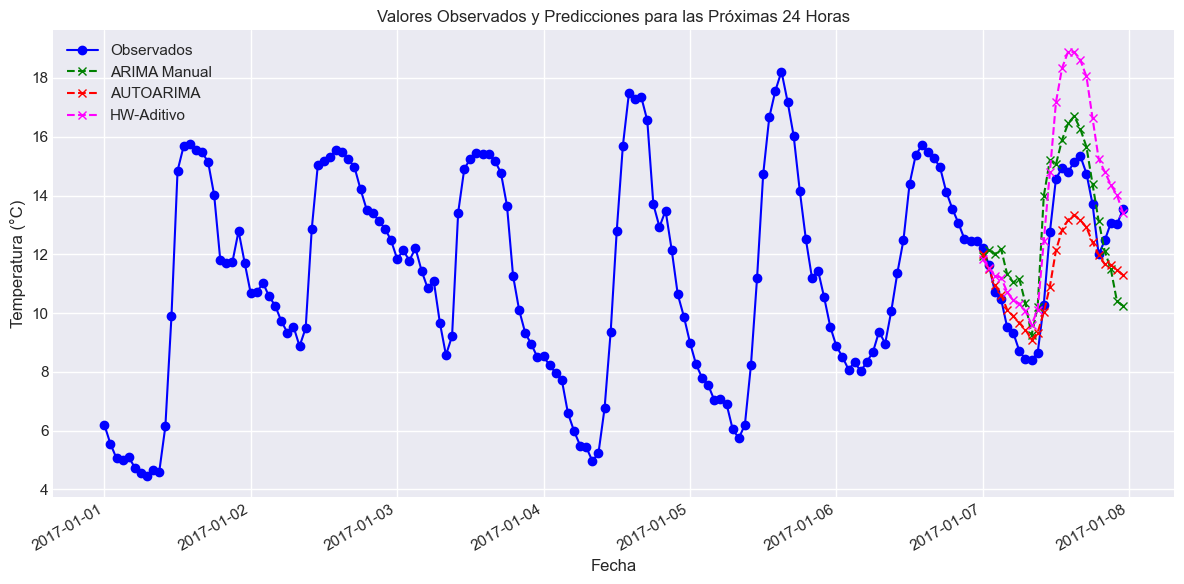

In [ ]:
### GRAFICAR TODOS LOS MODELOS Holt Winters, ARIMA Manual y AUTOARIMA
temperatura_tr.index.freq = 'H'

# Índice para las 24 horas siguientes
fechas_futuras = pd.date_range(start=temperatura_tr.index[-1] + pd.Timedelta(hours=1),
                                periods=24, freq='H')

# Alinear predicciones SARIMAX manual
pred_arima_manual = pd.Series(predicciones_statsmodels.values, index=fechas_futuras, name='ARIMA Manual')

# Alinear predicciones AUTOARIMA
pred_autoarima = pd.Series(predicciones_statsmodels2, index=fechas_futuras, name='AUTOARIMA')

# temp_s3 (Holt-Winters) también tenga las fechas correctas
pred_hw = pd.Series(temp_s3.values, index=fechas_futuras, name='HW Aditivo')

# Valores reales para comparación
valores_reales = temp_serie_hourly['Temperature'].loc[fechas_futuras]

plt.figure(figsize=(12, 6))

# Serie observada completa
plt.plot(temp_serie_hourly.index, temp_serie_hourly['Temperature'],
         label='Observados', marker='o', linestyle='-', color='blue')

# Predicciones
plt.plot(fechas_futuras, pred_arima_manual, label='ARIMA Manual', linestyle='--', color='green', marker='x')
plt.plot(fechas_futuras, pred_autoarima, label='AUTOARIMA', linestyle='--', color='red', marker='x')
plt.plot(fechas_futuras, pred_hw, label='HW-Aditivo', linestyle='--', color='magenta', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.title('Valores Observados y Predicciones para las Próximas 24 Horas')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
# Valores reales para el 7 de enero (las 24 horas reservadas)
datos_futuros = temp_serie_hourly['Temperature'].loc['2017-01-07']

# Índice de fechas para las predicciones
fechas_futuras = pd.date_range(start=temperatura_tr.index[-1] + pd.Timedelta(hours=1),
                                periods=24, freq='H')

# Predicciones alineadas
pred_arima_manual = pd.Series(predicciones_statsmodels.values, index=fechas_futuras)
pred_autoarima = pd.Series(predicciones_statsmodels2, index=fechas_futuras)
pred_hw = pd.Series(temp_s3.values, index=fechas_futuras)


# Validación ARIMA manual
mse_arima = mean_squared_error(datos_futuros, pred_arima_manual)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(datos_futuros, pred_arima_manual)

# Validación AUTOARIMA
mse_auto = mean_squared_error(datos_futuros, pred_autoarima)
rmse_auto = np.sqrt(mse_auto)
mae_auto = mean_absolute_error(datos_futuros, pred_autoarima)

# Validación Holt-Winters
mse_hw = mean_squared_error(datos_futuros, pred_hw)
rmse_hw = np.sqrt(mse_hw)
mae_hw = mean_absolute_error(datos_futuros, pred_hw)

print("🔍 VALIDACIÓN NUMÉRICA (24 horas)")

print("\n📘 ARIMA MANUAL:")
print(f"MSE  = {mse_arima:.4f}")
print(f"RMSE = {rmse_arima:.4f}")
print(f"MAE  = {mae_arima:.4f}")

print("\n📗 AUTOARIMA:")
print(f"MSE  = {mse_auto:.4f}")
print(f"RMSE = {rmse_auto:.4f}")
print(f"MAE  = {mae_auto:.4f}")

print("\n📙 HOLT-WINTERS Aditivo:")
print(f"MSE  = {mse_hw:.4f}")
print(f"RMSE = {rmse_hw:.4f}")
print(f"MAE  = {mae_hw:.4f}")


🔍 VALIDACIÓN NUMÉRICA (24 horas)

📘 ARIMA MANUAL:
MSE  = 3.0658
RMSE = 1.7509
MAE  = 1.5150

📗 AUTOARIMA:
MSE  = 1.8076
RMSE = 1.3445
MAE  = 1.1120

📙 HOLT-WINTERS Aditivo:
MSE  = 4.9684
RMSE = 2.2290
MAE  = 1.8961


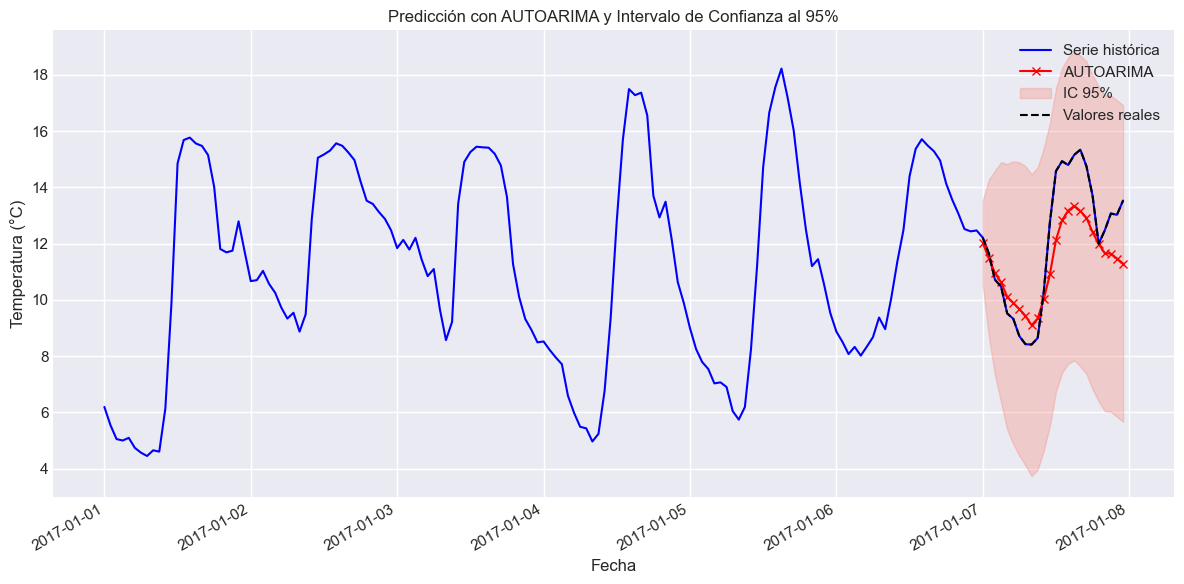

In [79]:
### GRAFICO AUTOARIMA
# Predecir con intervalo de confianza al 95%
preds_autoarima, conf_int_autoarima = modelo2.predict(n_periods=24, return_conf_int=True)

# Convertir a objetos pandas
preds_autoarima = pd.Series(preds_autoarima, index=fechas_futuras, name='AUTOARIMA')
conf_int_df = pd.DataFrame(conf_int_autoarima, index=fechas_futuras, columns=['Lower', 'Upper'])

plt.figure(figsize=(12, 6))

# Serie observada
plt.plot(temp_serie_hourly, label='Serie histórica', color='blue')

# Predicciones AUTOARIMA
plt.plot(preds_autoarima.index, preds_autoarima, label='AUTOARIMA', color='red', marker='x')

# Intervalo de confianza
plt.fill_between(preds_autoarima.index,
                 conf_int_df['Lower'],
                 conf_int_df['Upper'],
                 color='salmon', alpha=0.3, label='IC 95%')

# Valores reales para validación
plt.plot(valores_reales.index, valores_reales, label='Valores reales', linestyle='--', color='black')

plt.title('Predicción con AUTOARIMA y Intervalo de Confianza al 95%')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()